# Autoencoders 1 (Non-CNN model

## Simplest Autoencoder

In [85]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [86]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
# The size of our encoded representation
encoding_dim = 32 

# Input placeholder - array of 784 pixels
input_img = Input(shape=(784,))

The `encoding_dim` defines the dimension of the output to be produced by our encoding/compression function.

In this case, we are creating an encoder that will compress a 784 px array to a 32 dimensional array. 

In [89]:
"""`encoded` is a densely connected layer with `relu` activation that will map `input_img` to reduced dimensionality defined by `encoding_dim`"""
encoded = Dense(encoding_dim, activation='relu')(input_img)


"""`decoded` is another densely connected layer with `sigmoid` activation that will map the output of the `encoded` layer (i.e. the compressed/encoded representation of `input_img` to a 784-dimensional array)"""
decoded = Dense(784, activation='sigmoid')(encoded)

Have used the `keras` functional API to define the inputs, outputs, and activations for encoding and decoding layers. Will now combine both of them into a single model called `autoencoder` whose first layer (input) is `input_img` and last layer is `decoded`.

The model will therefore map the `input_img` to a decoded reconstruction. Don't need to specify `encoder` as a hidden layer because we have already defined it as the input to the `decoded` layer.

In [90]:
autoencoder = Model(input_img, decoded)

### Separate `encoder` Model
This model will simply map the input image to its encoded or compressed representation.

In [91]:
encoder = Model(input_img, encoded)

### Separate `decoder` Model
This model will map a compressed representation of an input with dimensionality of `encoding_dim` to a decompressed output representation.

In [92]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

### Training `autoencoder`

Training the autoencoder to reconstruct MNIST digits. 

In [93]:
# per-pixel binary crossentropy loss
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [94]:
# Preprocessing the input data - don't need labels because semi-supervised learning
(x_train, _), (x_test, _) = mnist.load_data()

In [95]:
# Normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape to 784-dimensional vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Print shapes
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Training for 50 Epochs

The target for each sample is the sample itself - the 'right answer' is the original image. The ideal autoencoder will be one that will embed 784 px image to 32 px and then reconstruct the original 784 px from the 32 px embedding.

This is also why `x_test` is passed as the label/target for the validation data.

In [96]:
autoenc_history = autoencoder.fit(x_train, x_train, 
               epochs=50, 
               batch_size=256, 
               shuffle=True, 
               validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2786 - val_loss: 0.1958
Epoch 2/50
60000/60000 [==============================] - 2s 40us/sample - loss: 0.1737 - val_loss: 0.1545
Epoch 3/50
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1449 - val_loss: 0.1335
Epoch 4/50
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1277 - val_loss: 0.1200
Epoch 5/50
60000/60000 [==============================] - 2s 41us/sample - loss: 0.1169 - val_loss: 0.1115
Epoch 6/50
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1099 - val_loss: 0.1057
Epoch 7/50
60000/60000 [==============================] - 3s 50us/sample - loss: 0.1049 - val_loss: 0.1016
Epoch 8/50
60000/60000 [==============================] - 2s 40us/sample - loss: 0.1013 - val_loss: 0.0986
Epoch 9/50
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0988 - val_

I had to switch the model's optimizer from `adadelta` to `adam` for the loss to converge. With `adadelta`, the loss hovered around 0.68 - 0.69, and decreased almost linearly.

In [99]:
def plot_training_history(history):
    hist = history.history
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(1, len(loss) + 1)
        
    plt.plot(epochs, loss, 'r-', label='Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.grid(True)
    plt.legend()

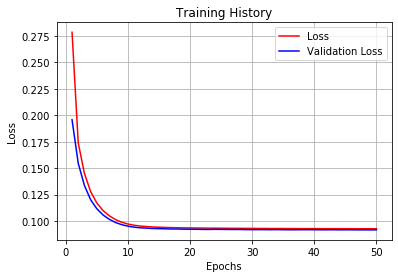

In [100]:
plot_training_history(autoenc_history)

In [101]:
# Encode the images 
encoded_imgs = encoder.predict(x_test)

# Decode the encoded images
decoded_imgs = decoder.predict(encoded_imgs)

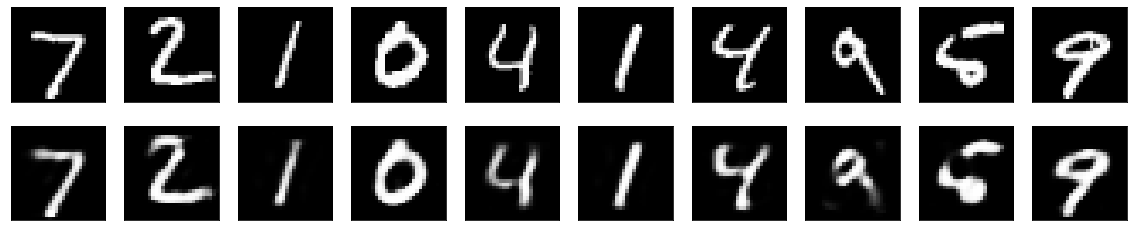

In [102]:
# Use matplotlib to plot the images

# Number of images to plot
n = 10 

plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Display reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Interpretation

The autoencoder works very well. Using 60,000 training images, it was able to learn how to compress the images to a 32-dimensional representation, and reconstruct them from the same representation with minimal loss.

## Sparsity Constraint


In original example, used the dimensionality of the encoded dimension (and thus the size of the hidden layer) to constrain the size of the encoding. 

Another way of making representations more compact is to add a sparsity constraint - only a subset of the units in a hidden layer will 'fire' at a time. 

**How is this different from `dropout`?**

In [103]:
from tensorflow.keras import regularizers

In [104]:
# Still encoding the 784-dimensional vectors into 32-dimensional vectors 
encoding_dim = 32

# Input is still 784-dimensional vector (flattened 28 by 28)
input_img = Input(shape=(784, ))

In [105]:
# Add a Dense layer with L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu', 
               activity_regularizer=regularizers.l1(10e-5))(input_img)

In [106]:
# Decoder layer is still the same
decoded = Dense(784, activation='sigmoid')(encoded)

In [107]:
# Create an autoencoder with L1 regularizer
autoencoder = Model(input_img, decoded)

In [109]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [110]:
sparse_autoenc_history = autoencoder.fit(x_train, x_train, 
               epochs=100, 
               batch_size=256, 
               shuffle=True, 
               validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2846 - val_loss: 0.1976
Epoch 2/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.1776 - val_loss: 0.1613
Epoch 3/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.1527 - val_loss: 0.1426
Epoch 4/100
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1374 - val_loss: 0.1303
Epoch 5/100
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1274 - val_loss: 0.1224
Epoch 6/100
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1207 - val_loss: 0.1168
Epoch 7/100
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1159 - val_loss: 0.1128
Epoch 8/100
60000/60000 [==============================] - 3s 46us/sample - loss: 0.1125 - val_loss: 0.1100
Epoch 9/100
60000/60000 [==============================] - 3s 46us/sample - loss: 0.11

Epoch 76/100
60000/60000 [==============================] - 2s 42us/sample - loss: 0.0978 - val_loss: 0.0969
Epoch 77/100
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0978 - val_loss: 0.0968
Epoch 78/100
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0977 - val_loss: 0.0968
Epoch 79/100
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0977 - val_loss: 0.0968
Epoch 80/100
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0977 - val_loss: 0.0968
Epoch 81/100
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0976 - val_loss: 0.0966
Epoch 82/100
60000/60000 [==============================] - 2s 42us/sample - loss: 0.0976 - val_loss: 0.0966
Epoch 83/100
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0976 - val_loss: 0.0966
Epoch 84/100
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0975 - val_loss: 0.0966
Epoch 85/100
60000/

Because we added L1 regularization to the encoder, we can train the model for more epochs without overfitting. This means we can obtain comparable performance to the original model. 

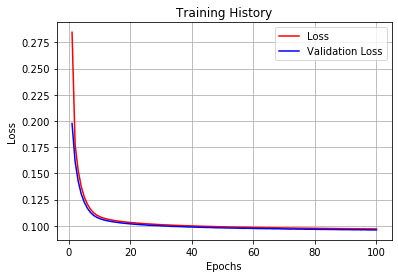

In [111]:
plot_training_historyistory_history(sparse_autoenc_history)

In [115]:
# Repeating the encoding/decoding process with test set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

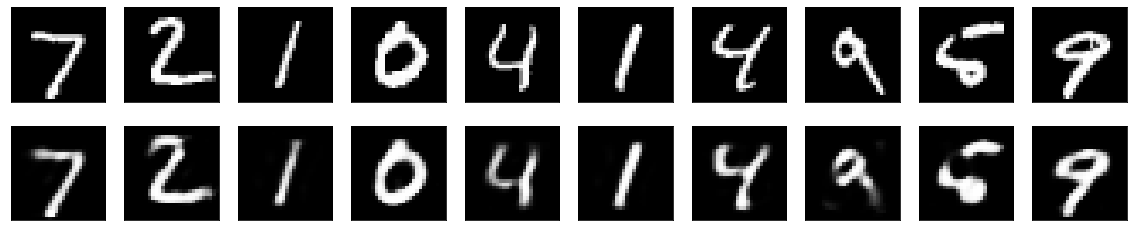

In [116]:
n = 10 

plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # Display reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [118]:
encoded_imgs.mean()

8.951278

### Interpretation
Even though this approach has a similar loss (and visual results) as the previous model, the encoded representations have greater sparsity - of the 32 floating-point values used to encode each image, a larger proportion are 0. 

However, the results I got with my implementation don't support his hypothesis - the mean value of the pixels is closer to the blog's value for the representations of the first model rather than the sparse one.

## Deep Autoencoder

Can use multiple layers of encoding and decoding. Such a network is called a deep autoencoder.

In [119]:
np.random.seed(42)

In [120]:
input_img = Input(shape=(784, ))

In [121]:
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

In [122]:
# The input to the first decoder layer is the output of the last encoder layer
decoded = Dense(64, activation='relu')(encoded)

# Previous layer's output is the input
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [123]:
deep_autoencoder = Model(input_img, decoded)

In [126]:
# Training without regularization on 100 epochs

In [129]:
deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [130]:
# Train
deep_autoenc_history = deep_autoencoder.fit(x_train,
                                            x_train, 
                                            epochs=100,
                                            batch_size=256,
                                            shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 76us/sample - loss: 0.2405 - val_loss: 0.1631
Epoch 2/100
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1480 - val_loss: 0.1362
Epoch 3/100
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1319 - val_loss: 0.1245
Epoch 4/100
60000/60000 [==============================] - 4s 65us/sample - loss: 0.1219 - val_loss: 0.1171
Epoch 5/100
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1148 - val_loss: 0.1112
Epoch 6/100
60000/60000 [==============================] - 5s 76us/sample - loss: 0.1108 - val_loss: 0.1079
Epoch 7/100
60000/60000 [==============================] - 5s 79us/sample - loss: 0.1079 - val_loss: 0.1055
Epoch 8/100
60000/60000 [==============================] - 5s 75us/sample - loss: 0.1053 - val_loss: 0.1029
Epoch 9/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.10

Epoch 76/100
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0826 - val_loss: 0.0825
Epoch 77/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0826 - val_loss: 0.0822
Epoch 78/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0825 - val_loss: 0.0823
Epoch 79/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0825 - val_loss: 0.0824
Epoch 80/100
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0825 - val_loss: 0.0823
Epoch 81/100
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0824 - val_loss: 0.0822
Epoch 82/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0824 - val_loss: 0.0821
Epoch 83/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0824 - val_loss: 0.0821
Epoch 84/100
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0824 - val_loss: 0.0820
Epoch 85/100
60000/

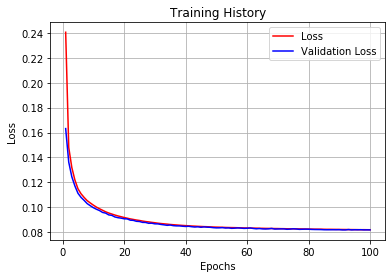

In [131]:
plot_training_history(deep_autoenc_history)

## Convolutional Autoencoder

When working with image data, it is common to use convolutional neural networks to create encoding and decoding functions. According to the the author, they just tend to perform better.

In [147]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [148]:
# When working with Conv2D, dont' need to flatten inputs
input_img = Input(shape=(28, 28, 1)) # Channels last

In [149]:
# First Conv-Pooling set
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

# Second Conv-Pooling set
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Third Conv-Pooling set - last pooling layer O/P is encoder O/P
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

At this point, the representation is (4, 4, 8) i.e. 128-dimensional.

In [150]:
# Decoder begins here
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# Second Conv2D and UpSampler
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Third Conv2D and UpSampler
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

# Final decoder result 
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [158]:
conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Data preprocessing will once again be a little different. Flattening no longer required. Input are in the form `(samples, channels, width, height)`. Must be reshaped accordingly.

Images will still be normalized by `MaxAbs` scaling.

In [153]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [154]:
(x_train, _), (x_test, _) = mnist.load_data()

In [155]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [156]:
print(x_train.shape)

(60000, 28, 28, 1)


In [157]:

print(x_test.shape)

(10000, 28, 28, 1)


Not using `tensorboard`. Will just plot the training history with `matplotlib`.

In [ ]:
conv_autoenc_history = conv_autoencoder.fit(x_train, x_train,
                                           epochs=50, 
                                           batch_size=128, 
                                           shuffle=True,
                                           validation_data=(x_test, x_test))

This is taking more than a minute per epoch. Does this mean the model will take ~50 minutes to train? Pls no.

Switching to CoLab. GPU does make a difference. Per-epoch time down from 70s to 4s.